# sin control variate for RMC
Polynomials are the most obvious order correcting CVs but that doesn't mean they are the best choice. This is an example to demonstrate you can use trig functions to do order correction which may have better extrapolation properties. 

Lets look at an example:
$$
y'=y, y(0)=1.
$$ 
integral equation (this is stable):
$$
y(t)= y(T) + \int_{T}^{t} y(s)ds.
$$ 
Now we need to correct $y(s)$ up to first order information:
$$
y(s) \approx c + b \sin(\alpha(s-T)).
$$ 
with Taylor it can be found that $c=b \alpha=y(T)$ correct up to first order. Then integrating the CV:
$$
\int_{T}^{t} y(T) + \frac{y(T)}{\alpha} \sin(\alpha(s-T)) ds = y(T) ( t-T-\frac{1}{\alpha^{2}}(\cos(\alpha(t-T)) -1)) .
$$ 
 





In [2]:
from random import random
from math import exp,pow,cos,sin
import matplotlib.pyplot as plt
import numpy as np
from numba import njit, prange

@njit(fastmath=True)
def Y_fast(t, T, yT, DT,alpha):
    sol = yT*(1 + t-T - (cos(alpha*(t-T))-1)/alpha**2) # vs  yT*(1 + (1-T)*(t-T)+ (t**2-T**2)/2)
    l = 10 # russian roulette rate l>1
    if random()*l < (t-T)/DT:
        S = T + random()*(t-T)  #\sim Uniform(T,t)
        sol += l*DT*(Y_fast(S, T, yT, DT,alpha) -yT*(1+sin(alpha*(S-T))/alpha)) #vs -yT*(1+S-T)
    return sol 

@njit(fastmath=True)
def Y_slow(T, DT: "step size slow recursion",alpha):
    y,t = 1.0,0.0
    while t<T:
        tt = t+DT if t+DT<T else T
        y = Y_fast(tt, t, y, tt-t,alpha) 
        t=tt
    return y


@njit(fastmath=True, parallel=True)
def solX(T, DT, nsim, alpha ):
    total = 0.0
    for _ in prange(nsim):
        total += Y_slow(T,DT,alpha)
    return total/nsim

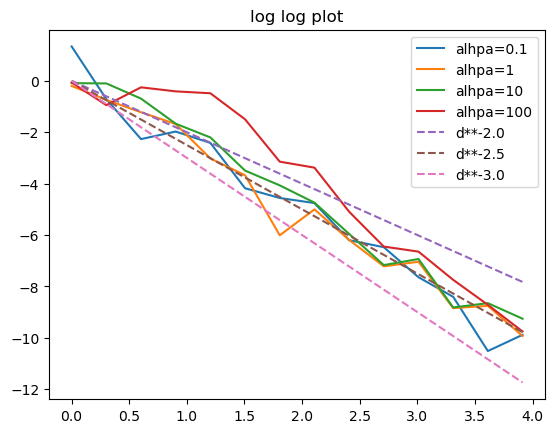

In [12]:

def CVRRMC_llplt():
    T = 10
    DTS = np.power(0.5,np.array(range(14)))
    alphas = [0.1,1,10,100]
    
    for alpha in alphas:
        errors = np.array([(abs(solX(T, d, 1,alpha )-exp(T)))/(exp(T)) for d in DTS])
        plt.plot(-np.log(DTS)/np.log(10),np.log(errors)/np.log(10), label = f"alhpa={alpha}")

    dgs = np.arange(2,3.5,0.5)
    for l in dgs:
        ref = np.array([pow(d,l) for d in DTS])
        plt.plot(-np.log(DTS)/np.log(10),np.log(ref)/np.log(10),label =f"d**-{l}",linestyle="dashed")
    plt.legend()
    plt.title("log log plot")
    plt.show()

CVRRMC_llplt()

We plotted the error for different $\alpha$ and for small time steps $\alpha$ has basically no influence in the meanwhile for big time steps is big $\alpha$ bad. From this we conjecture that for big time steps it doesn't matter as much what the asymptotic order of a method is what we  think that does matter is the $L_{2}$ - norm. In previous example this translates to at big time steps, big alpha doesn't work well because $exp$ doesn't get interpolated well by a high frequency sin wave. <br> 

The following code was one of our experiments, where we calculate linear functions that tries to minimize $L_{2}$ error to the solution to a ODE. The MC optimization was used as a benchmark:

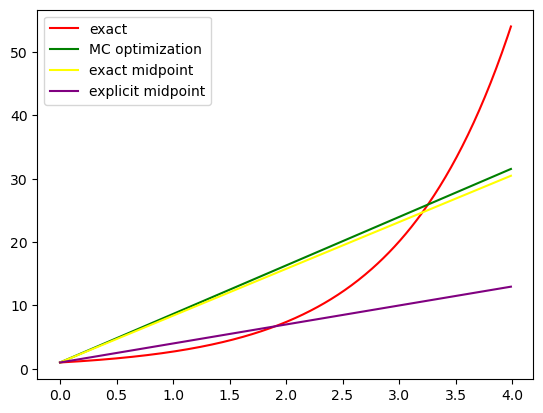

In [26]:
from random import random
import numpy as np
import matplotlib.pyplot as plt

def control(x,a): return a*x+1

def Y(t,a): 
    S = random()*t
    return 1+t +a*t**2/2 + ((Y(S,a)-control(S,a) if random()<t else 0) if t<1 else t*(Y(S,a)-control(S,a)) )

def A(t,a):
    S = random()*t  
    return a+ 3*(Y(S,a)- a*S-1)*S/t**2

t = 4
a_mid = 1+t/2
a,nsim = a_mid,10**3
for _ in range(2):
    a = sum(A(t,a) for _ in range(nsim))/nsim 

xs = np.arange(0,t,0.01)
ys = np.exp(xs)
zs = a*xs+1
qs  = np.exp(t/2)*xs+1
a_mid = 1+t/2
qs2 = a_mid*xs+1
plt.plot(xs,ys,color="red", label="exact")
plt.plot(xs,zs,color="green", label="MC optimization")
plt.plot(xs,qs,color="yellow", label="exact midpoint")
plt.plot(xs,qs2,color="purple", label="explicit midpoint")

plt.legend()
plt.show()

# CV in option pricing
Say you want to price a call option under the assumptions of the Black-Scholes model. The SDE for the underlying is:
$$
\frac{dS}{S} = r dt + \sigma dW.
$$ 
the solution of this SDE is known but many times this isn't the case. The CV techniques that we discussed so far always require knowledge of the underlying distribution. One way to side step this situation in this example is by linearlizing the SDE:
$$
\frac{d \tilde{S}}{S_{0}} = r dt + \sigma dW.
$$ 
where $\tilde{S}$ is normal distributed at maturity. The expected payoff of this linearlization can be calculated with the pieciwise MC trapizium rule or any other MC integrator. Now you can couple $\tilde{S}$ to $S$ and use it for control variating purposes. <br> 

TODO: example